# Analysis of Log Data

## Imports and Constants

In [72]:
import io
import os
from azure.storage.blob import BlockBlobService
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
STORAGE_ACCT_NAME = 'msftdevdayamlsa'# os.environ.get("STORAGE_ACCT_NAME")
STORAGE_ACCT_KEY = '6lAxxOTJ9ZfTv8IfZynuKP+1CigARIuf1PVLsXtEV/3+H4vFGLffiPirOHvdr7sFQHwl881kM2l5JsIXiyYZwA==' # os.environ.get("STORAGE_ACCT_KEY")
STORAGE_BLOB_NAME = 'data' # os.environ.get("STORAGE_BLOB_NAME")
TRAIN_PCT = 0.80

## Load Log Data from Blob Storage

In [74]:
block_blob_service = BlockBlobService(account_name=STORAGE_ACCT_NAME, account_key=STORAGE_ACCT_KEY)
obj = block_blob_service.get_blob_to_bytes(STORAGE_BLOB_NAME, 'log_data.pkl')
x, y = joblib.load(io.BytesIO(obj.content))
print(x.shape, y.shape)

(365, 3) (365,)


## Data Visualizations

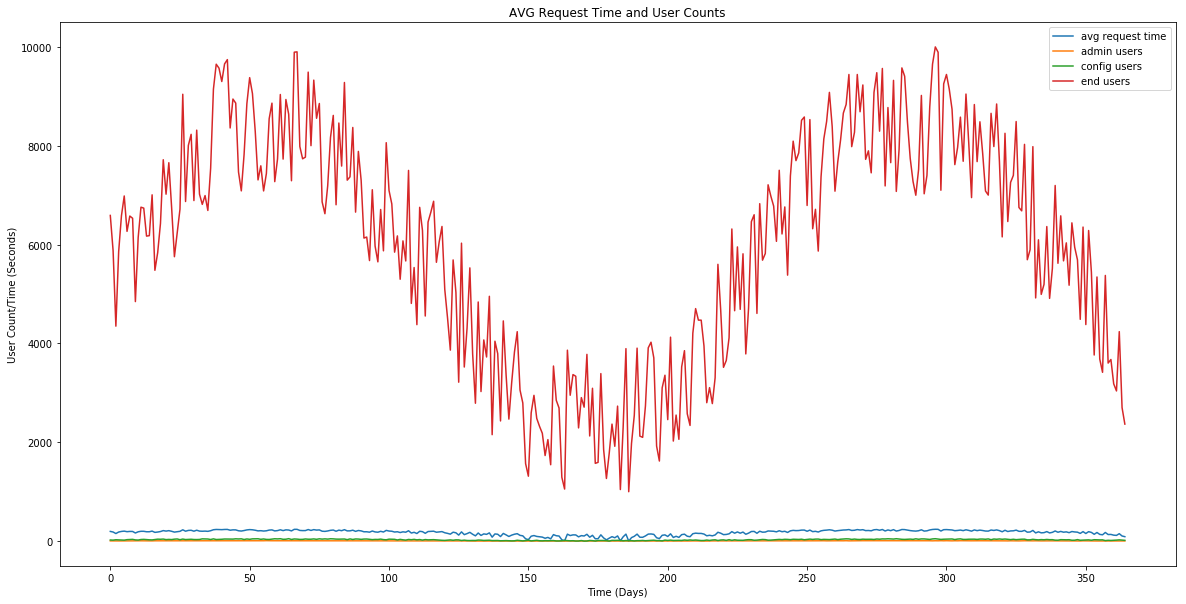

In [75]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

fig = plt.figure(figsize=(20,10))
plt.title('AVG Request Time and User Counts')
plt.xlabel('Time (Days)')
plt.ylabel('User Count/Time (Seconds)')
plt.plot(y, label='avg request time')
plt.plot([x[0] for x in x], label='admin users')
plt.plot([x[1] for x in x], label='config users')
plt.plot([x[2] for x in x], label='end users')
plt.legend()
plt.savefig('unnormalized_stats.png', bbox_inches='tight')
plt.show()

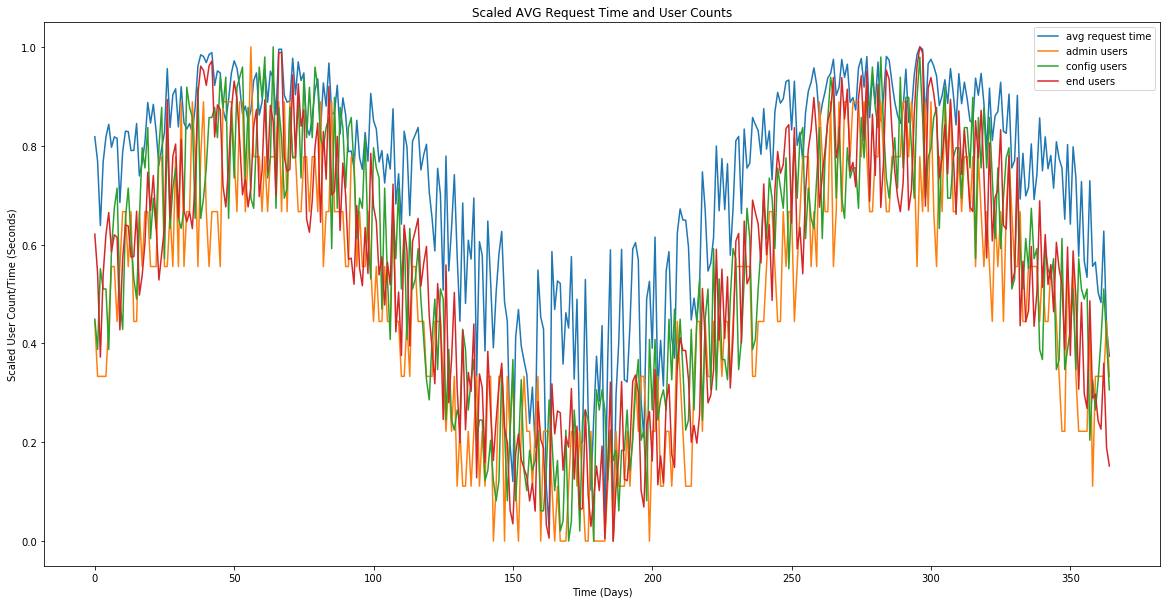

In [76]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

fig = plt.figure(figsize=(20,10))
plt.title('Scaled AVG Request Time and User Counts')
plt.xlabel('Time (Days)')
plt.ylabel('Scaled User Count/Time (Seconds)')
scaler = MinMaxScaler()
time = [y for y in y]
scaled_time = scaler.fit_transform(np.array(time).reshape((-1,1)))
plt.plot(scaled_time, label='avg request time')
admin = [float(x[0]) for x in x]
scaled_end_users = scaler.fit_transform(np.array(admin).reshape((-1,1)))
plt.plot(scaled_end_users, label='admin users')
config = [float(x[1]) for x in x]
scaled_end_users = scaler.fit_transform(np.array(config).reshape((-1,1)))
plt.plot(scaled_end_users, label='config users')
end = [float(x[2]) for x in x]
scaled_end_users = scaler.fit_transform(np.array(end).reshape((-1,1)))
plt.plot(scaled_end_users, label='end users')
plt.legend()
plt.savefig('normalized_stats.png', bbox_inches='tight')
plt.show()

In [88]:
def moving_avg(x, window, method='lookback'):
    result = []
    if method == 'lookback':
        for i in range(len(x)-window+1):
            result.append(sum(x[i:i+window])/float(window))
        result = [result[0]] * (len(x) - len(result)) + result
    elif method == 'lookforward':
        result.extend([x[0]]*(window-1))
        for i in range(window, len(x)):
            result.append(sum(x[i-window:i])/float(window))
    else: # centered
        result.append(x[0])
        for i in range(window//2, len(x)-1):
            #print(i-(window//2), i+(window//2+1), sum(x[i-window//2:i+(window//2+1)]), sum(x[i-window//2:i+(window//2+1)])/float(window))
            result.append(sum(x[i-window//2:i+(window//2+1)])/float(window))
        result = [result[0]] + result
        result.append(result[-1])
    return result

l = [i for i in range(10)]
#print(l)
# print(moving_avg(l, 3, method='lookback'))
# print(moving_avg(l, 3, method='lookforward'))
print(moving_avg(l, 5, method='centered'))

[0, 0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 6.0, 6.0]


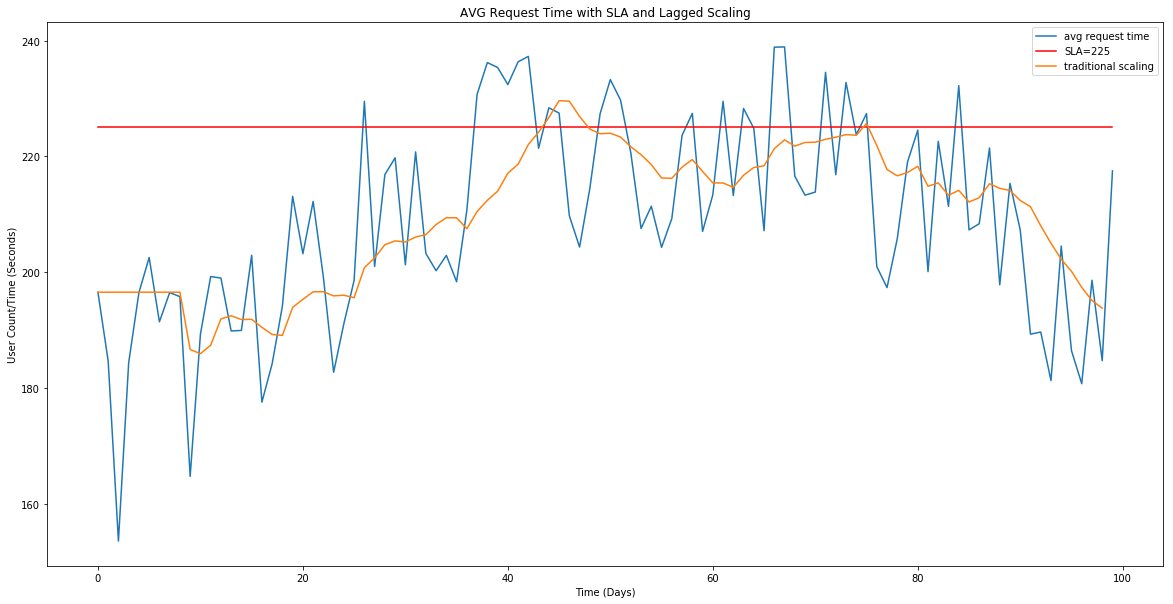

In [78]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

sla = 225
times = y[:100]
lagged = moving_avg(times, window=10, method='lookforward')

fig = plt.figure(figsize=(20,10))
plt.title('AVG Request Time with SLA and Lagged Scaling')
plt.xlabel('Time (Days)')
plt.ylabel('User Count/Time (Seconds)')
plt.plot(times, label='avg request time')
plt.plot([sla for i in range(len(times))], label='SLA=' + str(sla), color='red')
plt.plot(lagged, label='traditional scaling')
plt.legend()
#plt.savefig('traditional_scaling.png', bbox_inches='tight')
plt.show()

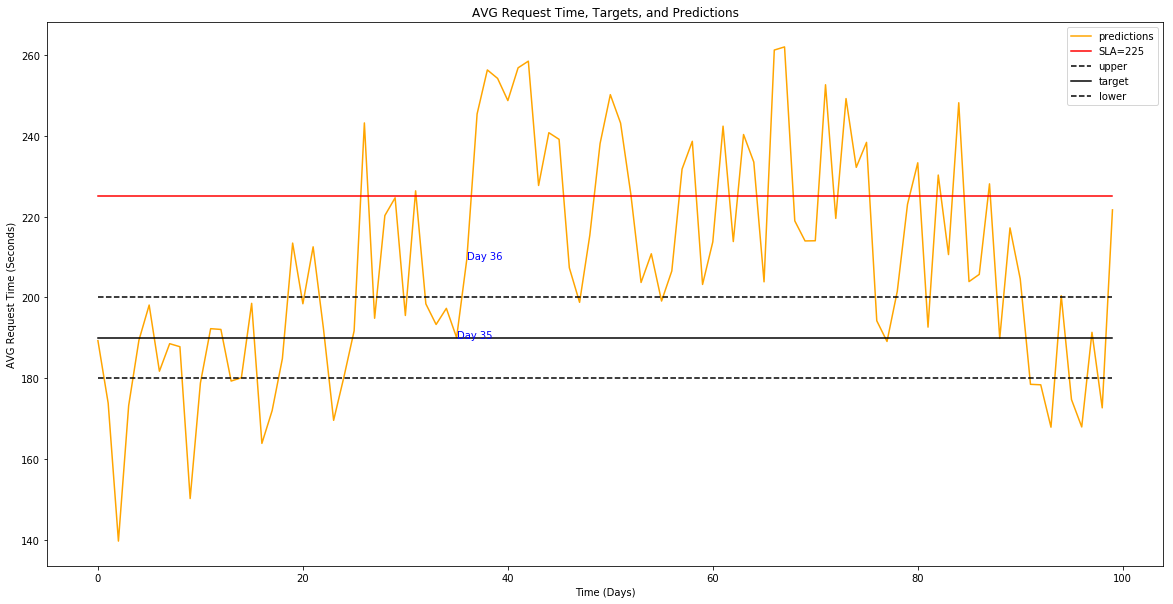

In [117]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

times = y[:100]
sla = 225
target = 190
threshold = 10
predictions = model.predict(x[:100])

fig = plt.figure(figsize=(20,10))
plt.title('AVG Request Time, Targets, and Predictions')
plt.xlabel('Time (Days)')
plt.ylabel('AVG Request Time (Seconds)')
plt.plot(predictions, label='predictions', color='orange')
plt.plot([sla for i in range(len(times))], label='SLA=225', color='red')
plt.annotate('Day 35', (35, predictions[35]), color='blue')
plt.annotate('Day 36', (36, predictions[36]), color='blue')
plt.plot([target + threshold for i in range(len(times))], label='upper', linestyle='--', color='black')
plt.plot([target for i in range(len(times))], label='target', color='black')
plt.plot([target - threshold for i in range(len(times))], label='lower', linestyle='--', color='black')
plt.legend()
plt.savefig('proactive_scaling_policy.png', bbox_inches='tight')
plt.show()

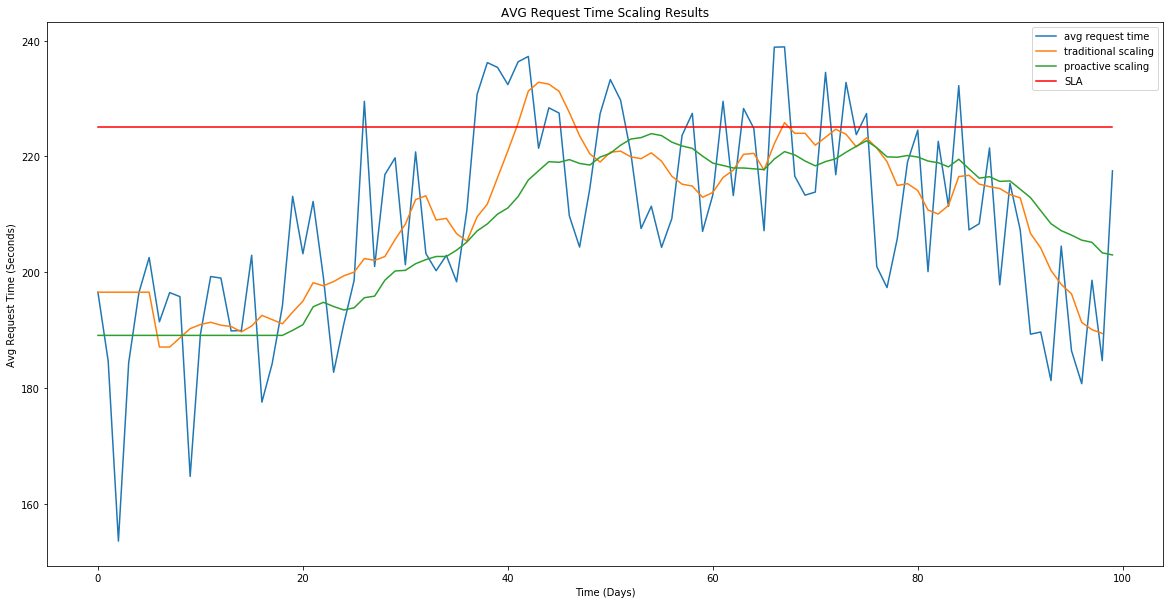

In [116]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

times = y[:100]
sla = 225
target = 190
threshold = 10
predictions = model.predict(x[:100])
trad = moving_avg(times, window=7, method='lookforward')
pro = moving_avg(times, window=19, method='lookback')

fig = plt.figure(figsize=(20,10))
plt.title('AVG Request Time Scaling Results')
plt.xlabel('Time (Days)')
plt.ylabel('Avg Request Time (Seconds)')
plt.plot(times, label='avg request time')
plt.plot(trad, label='traditional scaling')
plt.plot(pro, label='proactive scaling')
plt.plot([sla for i in range(len(times))], label='SLA', color='red')
plt.legend()
plt.savefig('proactive_scaling.png', bbox_inches='tight')
plt.show()

## Preparing Data for Algorithm

In [11]:
split_at = int(x.shape[0] * TRAIN_PCT)
x_train = x[:split_at]
x_test = x[split_at:]
y_train = y[:split_at]
y_test = y[split_at:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(292, 3) (292,) (73, 3) (73,)


In [12]:
x[0], y[0]

(array([   5,   23, 6590]), 196.56236655445082)

## Train and Evaluate Model

In [13]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [14]:
print('R2', r2_score(y_pred, y_test))

R2 0.934136729765839


## Visually Inspect Predictions

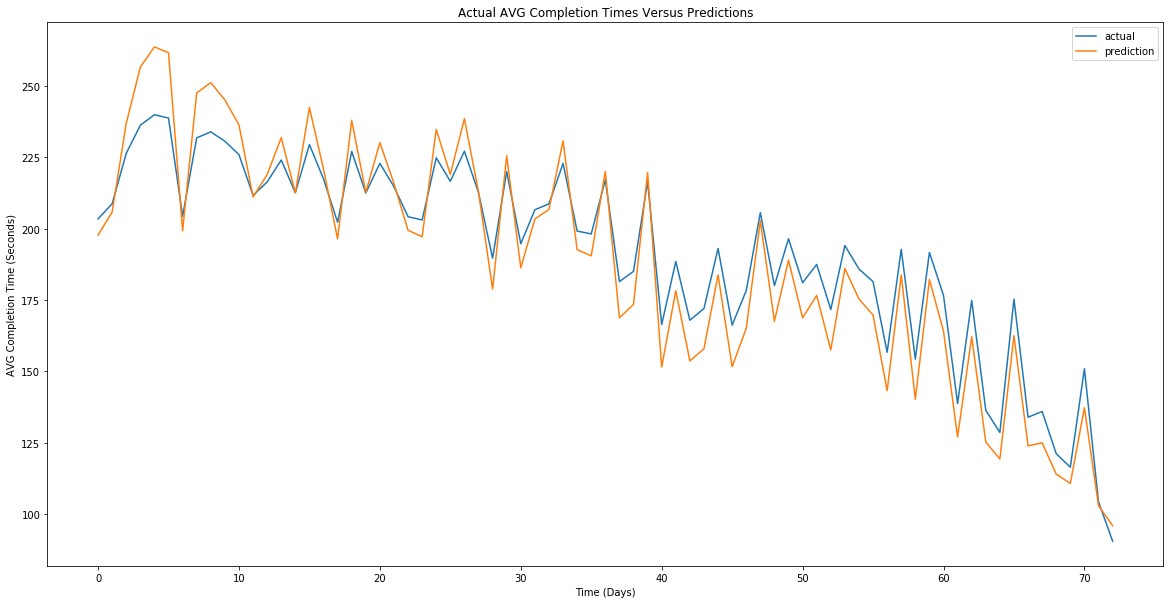

In [183]:
plt.figure(figsize=(20,10))
plt.title('Actual AVG Completion Times Versus Predictions')
plt.xlabel('Time (Days)')
plt.ylabel('AVG Completion Time (Seconds)')
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.savefig('actual_vs_predictions.png', bbox_inches='tight')
plt.show()